# CS 109A/AC 209A/STAT 121A Data Science: Final Project
**Harvard University**<br>
**Fall 2016**<br>
**Instructors:** W. Pan, P. Protopapas, K. Rader<br>
**Members: ** Shawn Pan, Xinyuan (Amy) Wang, Ming-long Wu

## Location Clustering Analysis ##

- Do KNN on locations to find spatial clusters
- Use location_cluster to replace ['zipcode', 'latitude', 'longitude'] as a single predictor
- Reduces issues with zipcode of small sample size
- Speeds up model fitting with fewer indicator columns
- OLS from the new model gets R^2 of about 0.66

In [2]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
import statsmodels.api as sm
from itertools import combinations
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from collections import Counter
%matplotlib inline

In [7]:
#read the data
df = pd.read_csv('../../Data/listings_clean.csv')
print df.shape
df.head()

(27392, 31)


,id,host_since,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,price
0,1069266,1926,10022.0,40.756852,-73.964754,0,0,2,1.0,1.0,...,2542.0,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1,160
1,1846722,1625,NaN,40.830599,-73.941014,0,0,10,1.0,3.0,...,2554.0,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2,105
2,2061725,1831,11221.0,40.692189,-73.924120,0,1,2,1.0,1.0,...,2554.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4,58
3,44974,953,10011.0,40.734751,-74.002592,0,0,2,1.0,1.0,...,2494.0,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1,185
4,4701675,2479,10011.0,40.745282,-73.997836,0,0,2,1.0,1.0,...,2533.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,195


In [8]:
location_model = KNeighborsRegressor(n_neighbors=50, weights="uniform")
x = df[["latitude", "longitude"]]
y = np.log(df["price"])

location_model.fit(x, y)
location_model.score(x, y)

0.33622833614690817

In [9]:
df.loc[:,'loc_knn'] = pd.Series(location_model.predict(x), index=df.index)

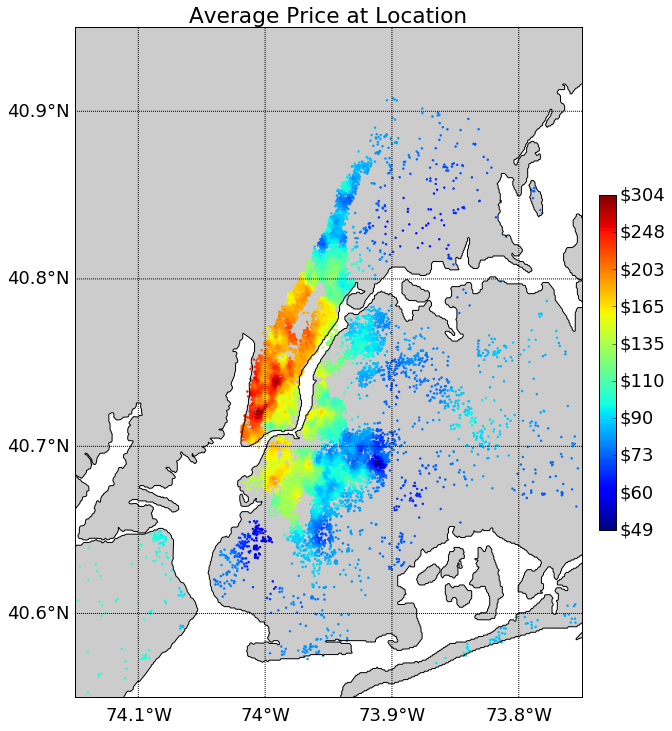

In [164]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(10, 12))

# setup mercator map projection
# run with low resolution 'l' to debug faster 
m = Basemap(llcrnrlon=-74.15,llcrnrlat=40.55,
            urcrnrlon=-73.75,urcrnrlat=40.95,
            resolution='f',projection='merc')

# draw map
m.drawcoastlines()
m.fillcontinents(zorder=0)

# draw parallels and meridians
m.drawparallels(np.arange(40, 41, 0.1), labels=[1, 0, 0, 1])
m.drawmeridians(np.arange(-74.5, -73.5, 0.1), labels=[1, 0, 0, 1])

# draw locations
x, y = m(df["longitude"].as_matrix(), df["latitude"].as_matrix())
m.scatter(x, y, c=df["loc_knn"], s=6, edgecolors='none')

# title and colorbar
plt.title("Average Price at Location")
log_price_range = np.linspace(np.min(df["loc_knn"]), np.max(df["loc_knn"]), 10)
cbar = plt.colorbar(ticks=log_price_range, fraction=0.03, pad=0.03)
price_range = np.round(np.exp(log_price_range)).astype(np.int)
cbar.ax.set_yticklabels(["$" + str(p) for p in price_range]);

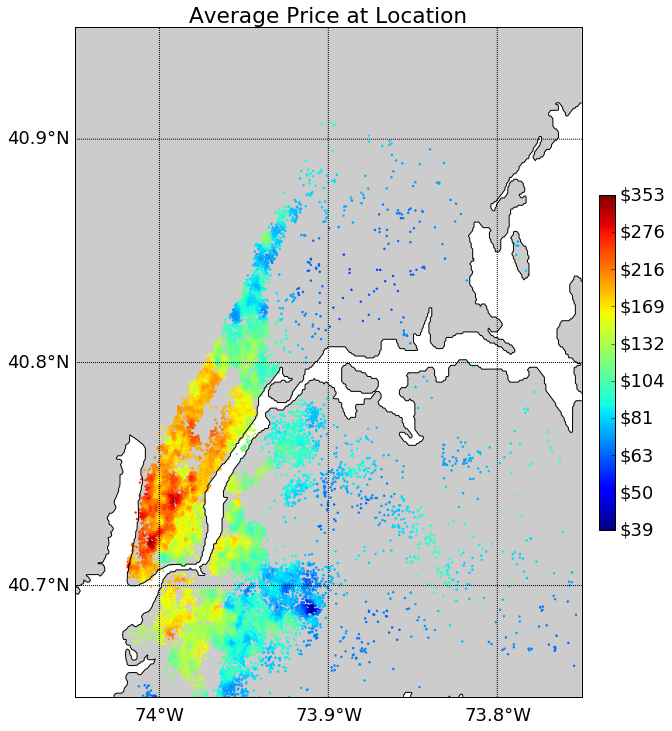

In [17]:
#Zoomed in version
plt.figure(figsize=(10, 12))

# setup mercator map projection
# run with low resolution 'l' to debug faster 
m = Basemap(llcrnrlon=-74.05,llcrnrlat=40.65,
            urcrnrlon=-73.75,urcrnrlat=40.95,
            resolution='f',projection='merc')

# draw map
m.drawcoastlines()
m.fillcontinents(zorder=0)

# draw parallels and meridians
m.drawparallels(np.arange(40, 41, 0.1), labels=[1, 0, 0, 1])
m.drawmeridians(np.arange(-74.5, -73.5, 0.1), labels=[1, 0, 0, 1])

# draw locations
x, y = m(df["longitude"].as_matrix(), df["latitude"].as_matrix())
m.scatter(x, y, c=df["loc_knn"], s=6, edgecolors='none')

# title and colorbar
plt.title("Average Price at Location")
log_price_range = np.linspace(np.min(df["loc_knn"]), np.max(df["loc_knn"]), 10)
cbar = plt.colorbar(ticks=log_price_range, fraction=0.03, pad=0.03)
price_range = np.round(np.exp(log_price_range)).astype(np.int)
cbar.ax.set_yticklabels(["$" + str(p) for p in price_range]);

In [60]:
#Feature Extraction:
#Use the features we decided last time
features = [#'zipcode', 'latitude', 'longitude',
            'loc_knn',
            'property_type', 'room_type', 'accommodates', 
            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'number_of_reviews', 'review_scores_rating',
            'review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 
            'review_scores_location', 'review_scores_value', 'host_listing_count']

df_x = df1[features]
df_x.head()

,loc_knn,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,5.225984,0,0,2,1.0,1.0,1.0,0,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
1,4.451333,0,0,10,1.0,3.0,3.0,0,22,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2
2,4.384747,0,1,2,1.0,1.0,2.0,0,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4
3,5.489792,0,0,2,1.0,1.0,1.0,0,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1
4,5.266825,0,0,2,1.0,1.0,2.0,0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1


Now we start imputing missing values. We fill in numerical values with the mean of its columns, fill in categorical values with most common value of its column.

In [61]:
#categorical and numerical column names
cate = ['property_type', 'room_type', 'bed_type'] #'zipcode', 
nume = [c for c in df_x.columns.values if c not in cate]

#fill categorical with mode, numerical with mean
df_x_cate = df_x[cate].apply(lambda x:x.fillna(x.value_counts().index[0]))
df_x_nume = df_x[nume].apply(lambda x:x.fillna(x.mean()))

df_x = pd.concat([df_x_cate, df_x_nume], axis=1)
df_x.head()

,property_type,room_type,bed_type,loc_knn,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count
0,0,0,0,5.225984,2,1.0,1.0,1.0,62,86.0,9.0,7.0,9.0,9.0,10.0,9.0,1
1,0,0,0,4.451333,10,1.0,3.0,3.0,22,85.0,8.0,8.0,9.0,8.0,7.0,8.0,2
2,0,1,0,4.384747,2,1.0,1.0,2.0,35,98.0,10.0,10.0,10.0,10.0,9.0,10.0,4
3,0,0,0,5.489792,2,1.0,1.0,1.0,26,96.0,10.0,9.0,10.0,10.0,10.0,9.0,1
4,0,0,0,5.266825,2,1.0,1.0,2.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1


Now we encode categorical variables.

In [62]:
# Get numpy array from data
x = df_x.values

# Apply one hot endcoing
categorical = [(c in cate) for c in df_x.columns]
encoder = preprocessing.OneHotEncoder(categorical_features=categorical, sparse=False)  

x = encoder.fit_transform(x)
x

array([[  1.,   0.,   0., ...,  10.,   9.,   1.],
       [  1.,   0.,   0., ...,   7.,   8.,   2.],
       [  1.,   0.,   0., ...,   9.,  10.,   4.],
       ..., 
       [  0.,   1.,   0., ...,   9.,   8.,  15.],
       [  1.,   0.,   0., ...,   9.,  10.,   7.],
       [  1.,   0.,   0., ...,  10.,  10.,   2.]])

In [63]:
print x.shape
print y.shape

(27392, 28)
(27392,)


Now we've already preprocessed data in both files. We could start build models. We split our training dataset into train data and test data.

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, np.log(y), test_size=0.3, random_state=0)

In [53]:
print 'train data: ', x_train.shape
print 'test data: ', x_test.shape

train data:  (19174, 28)
test data:  (8218, 28)


In [65]:
#OLS
X = sm.add_constant(x_train)
model = sm.OLS(y_train,X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1518.
Date:                Wed, 07 Dec 2016   Prob (F-statistic):               0.00
Time:                        12:56:45   Log-Likelihood:                -8176.7
No. Observations:               19174   AIC:                         1.641e+04
Df Residuals:                   19148   BIC:                         1.661e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       3.608e+09      1e+10      0.360      0.7

$R^2$ is 0.663

In [66]:
#same OLS model with sklearn (easier to score but less detailed output)
model = LinearRegression()
model.fit(x_train, y_train)
print "Train Score", model.score(x_train, y_train)
print "Test Score", model.score(x_test, y_test)

Train Score 0.66469453577
Test Score 0.676337110068


Interestingly, for this split the test set does better than the training set.

In [56]:
#try several random seeds to check for stability and variance
for r in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, np.log(y), test_size=0.3, random_state=r)
    model = LinearRegression()
    model.fit(x_train, y_train)
    print "Train {:.3f} Test {:.3f}".format(model.score(x_train, y_train), model.score(x_test, y_test))

Train 0.674 Test 0.681
Train 0.677 Test 0.674
Train 0.680 Test 0.668
Train 0.679 Test 0.671
Train 0.681 Test 0.665
Train 0.680 Test 0.668
Train 0.673 Test 0.685
Train 0.678 Test 0.672
Train 0.675 Test 0.680
Train 0.683 Test 0.660
